# Описание проекта

Случай аналитика из компании «Мегалайн» — федерального оператора сотовой связи.

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В выгрузке данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Задача проекта - проанализировать поведение клиентов и сделать вывод — какой из 2-х тарифов лучше.

# Описание тарифов

**Тариф «Смарт»**

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета: 
- 1. 1 минута разговора: 3 рубля;
- 2. 1 сообщение: 3 рубля;
- 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета: 
- 1. 1 минута разговора: 1 рубль;
- 2. 1 сообщение: 1 рубль;
- 3. 1 Гб интернет-трафика: 150 рублей.

**Важная ремарка**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Каждый потраченный мегабайт округляется до гигабайта: потратил хотя бы 100 Мб, спишут как за 1 Гб (1 Гб - это 1024 Мб).

In [1]:
# импорт библиотек
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats as st
from datetime import datetime

In [2]:
# функция для вывода общей информации о датасете
def data_main_info(data):
    
    # вывод шапки и общей информации
    print('Шапка и общая информация о данных')
    display(data.head(10))
    print(data.info())
    print()
    
    # Вывод статистической информации о датасете
    print('Статистическая информация о данных')
    display(data.describe())
    print()
    
    # Подсчет и вывод количества явных дубликатов в данных
    print('Количество явных дубликатов в данных:', data.duplicated().sum())
    print()
    
    # Подсчет и вывод количества пропусков по столбцам
    print('Количество пропусков в данных')
    display(data.isna().sum().sort_values(ascending=False))

# Изучение данных, предобработка и подготовка

## Изучение данных

Посмотрим на каждый датасет по отдельности.

In [3]:
# данные по звонкам
calls = pd.read_csv('/Users/danilvlasenko/Desktop/calls.csv')

# общая информация о звонках
data_main_info(calls)

Шапка и общая информация о данных


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

Статистическая информация о данных


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000



Количество явных дубликатов в данных: 0

Количество пропусков в данных


user_id      0
duration     0
call_date    0
id           0
dtype: int64

В данных по звонкам имеем 4 столбца:
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

Пропущенные значения и явные дубликаты отсутствуют.

В столбце `call_date` указан тип данных *object*. Для корректного использования дат по месяцам и годам стоит привести значения в тип *datetime*

В столбце `id` указан тип данных *odject*. Это уникальный номер звонка, который не должен быть *object*, имеет смысл изменить тип данных на *int*.

In [4]:
# данные по интернет-сессиям
internet = pd.read_csv('/Users/danilvlasenko/Desktop/internet.csv')

# общая информация об интернет-сессиях
data_main_info(internet)

Шапка и общая информация о данных


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

Статистическая информация о данных


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000



Количество явных дубликатов в данных: 0

Количество пропусков в данных


user_id         0
session_date    0
mb_used         0
id              0
Unnamed: 0      0
dtype: int64

В данных по интернет-сессиям имеем 4 столбца:
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Пропущенные значения и явные дубликаты отсутствуют.

В столбце `session_date` указан тип данных *object*. Для корректного использования дат по месяцам и годам стоит привести значения в тип *datetime*.

В столбце `id` указан тип данных *odject*. Это уникальный номер сессии, который не должен быть *object*, имеет смысл изменить тип данных на *int*.

Имеется непонятный столбец `Unnamed: 0`. Скорее всего, он совпадает с индексами. Посмотрим на 10 последних строк в данных, и если это так, удалим его сразу же - он точно не понадобится.

In [5]:
# просмотр последних 10 строк
internet.tail(10)

,Unnamed: 0,id,mb_used,session_date,user_id
149386,149386,1499_147,0.00,2018-10-21,1499
149387,149387,1499_148,268.19,2018-11-13,1499
149388,149388,1499_149,778.68,2018-11-24,1499
149389,149389,1499_150,273.98,2018-11-20,1499
149390,149390,1499_151,752.72,2018-10-11,1499
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


In [6]:
# действительно так. Удаляем
internet.drop(columns='Unnamed: 0', axis=1, inplace=True)
internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [7]:
# данные по сообщениям
messages = pd.read_csv('/Users/danilvlasenko/Desktop/messages.csv')

# общая информация о сообщениях
data_main_info(messages)

Шапка и общая информация о данных


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None

Статистическая информация о данных


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000



Количество явных дубликатов в данных: 0

Количество пропусков в данных


user_id         0
message_date    0
id              0
dtype: int64

В данных по сообщениям имеем 3 столбца:
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

Пропущенные значения и явные дубликаты отсутствуют.

В столбце `message_date` указан тип данных *object*. Для корректного использования дат по месяцам и годам стоит привести значения в тип *datetime*.

В столбце `id` указан тип данных *odject*. Это уникальный сообщения, который не должен быть *object*, имеет смысл изменить тип данных на *int*.

In [8]:
# данные по тарифам
tariffs = pd.read_csv('/Users/danilvlasenko/Desktop/tariffs.csv')

# общая информация о тарифах
data_main_info(tariffs)

Шапка и общая информация о данных


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None

Статистическая информация о данных


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000



Количество явных дубликатов в данных: 0

Количество пропусков в данных


tariff_name              0
rub_per_minute           0
rub_per_message          0
rub_per_gb               0
rub_monthly_fee          0
minutes_included         0
mb_per_month_included    0
messages_included        0
dtype: int64

В данных по 2-м тарифам имеем 8 столбцов:
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Типы данных указаны корректно. Возможно, по этому датасету в будущем можно будет рассчитать полные суммы, потраченные на тариф каждым пользователем.

In [9]:
# данные по пользователям
users = pd.read_csv('/Users/danilvlasenko/Desktop/users.csv')

# общая информация о пользователях
data_main_info(users)

Шапка и общая информация о данных


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

Статистическая информация о данных


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000



Количество явных дубликатов в данных: 0

Количество пропусков в данных


churn_date    462
tariff          0
reg_date        0
last_name       0
first_name      0
city            0
age             0
user_id         0
dtype: int64

В данных по пользователям имеем 8 столбцов:
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана


В столбце `churn_date` (дата прекращения пользования тарифом) заполнено всего 38 значений. Заполнять пропуски не стоит.

**Из 500 пользователей активных 468**.

Явные дубликаты отсутствуют.

В столбцах `churn_date` и `reg_date` указан тип данных *object*. Для корректного использования дат по месяцам и годам стоит привести значения в тип *datetime*

**Выводы:**

Представлено 5 датасетов, предварительное изучение дало следующие факты:
- 1) Из 500 пользователей в базе активными являются 468
- 2) В столбцах с датами указан тип данных *object*, при этом даты отображатся корректно - стоит изменить на *datetime* для дальнейшей работы
- 3) В столбцах user_id в данных по звонкам, интернет-сессиям и сообщениям указан не совсем верный тип данных *object*. Приведем тип к *int*

Для дальнейшего анализа датасеты стоит соединить между собой. Предварительно, очень напрашивается датасет с общим количеством минут, Мб трафика и сообщений по каждому пользователю с указанием тарифов. Это даст возможность рассчитать общую выручку по каждому тарифу.

## Предобработка данных

В этом разделе изменим типы данных в некоторых датасетах, заполнение пропусков не требуется.

Также необходимо учесть жадную политику компании и округлить минуты и Мб до Гб в большую сторону.

In [10]:
# изменение типов данных в calls
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['id'] = calls['id'].astype('int')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null int64
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 6.2 MB


In [11]:
# изменение типов данных в internet
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['id'] = internet['id'].astype('int')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null int64
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 4.6 MB


In [12]:
# изменение типов данных в messages
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['id'] = messages['id'].astype('int')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null int64
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


In [13]:
# изменение типов данных в users
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


В случае минут, округляем значения в `calls` простым способом. В случае трафика, поделим значения в Мб на 1024 - получим Гб, затем их округлим в большую сторону.

In [14]:
# округление значений по длительности звонков
calls['duration'] = calls['duration'].apply(np.ceil)

In [15]:
# получение Гб из Мб и округление в большую сторону
internet['mb_used'] = (internet['mb_used'] / 1024).apply(np.ceil)

# переименование столбца
internet = internet.rename(columns={'mb_used':'gb_used'})

**Вывод:** типы данных изменены, датасеты подготовлены для расчетов и анализа.

### Подготовка данных

В этом разделе рассчитаем параметры для каждого пользователеля по месяцам:
- 1) Количество сделанных звонков и израсходованных минут разговора;
- 2) Количество отправленных сообщений;
- 3) Объем израсходованного интернет-трафика по месяцам;
- 4) Выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Добавим в каждый датасет (`calls`, `internet`, `messages`) новые столбцы с месяцами.

In [16]:
# чуть-чуть автоматизируем
def month_apply(data, date_column):
    data['month'] = pd.DatetimeIndex(data[date_column]).month
    
    return data

In [17]:
# для calls
month_apply(calls, 'call_date')
calls.head(10)

,id,call_date,duration,user_id,month
0,10000,2018-07-25,0.0,1000,7
1,10001,2018-08-17,0.0,1000,8
2,10002,2018-06-11,3.0,1000,6
3,10003,2018-09-21,14.0,1000,9
4,10004,2018-12-15,6.0,1000,12
5,10005,2018-11-02,0.0,1000,11
6,10006,2018-10-18,0.0,1000,10
7,10007,2018-08-22,19.0,1000,8
8,10008,2018-09-15,19.0,1000,9
9,10009,2018-08-15,0.0,1000,8


In [18]:
# для messages
month_apply(messages, 'message_date')
messages.head(10)

,id,message_date,user_id,month
0,10000,2018-06-27,1000,6
1,10001,2018-10-08,1000,10
2,10002,2018-08-04,1000,8
3,10003,2018-06-16,1000,6
4,10004,2018-12-05,1000,12
5,10005,2018-06-20,1000,6
6,10006,2018-11-19,1000,11
7,10007,2018-10-29,1000,10
8,10008,2018-06-25,1000,6
9,10009,2018-12-18,1000,12


In [19]:
# для internet
month_apply(internet, 'session_date')
messages.head(10)

,id,message_date,user_id,month
0,10000,2018-06-27,1000,6
1,10001,2018-10-08,1000,10
2,10002,2018-08-04,1000,8
3,10003,2018-06-16,1000,6
4,10004,2018-12-05,1000,12
5,10005,2018-06-20,1000,6
6,10006,2018-11-19,1000,11
7,10007,2018-10-29,1000,10
8,10008,2018-06-25,1000,6
9,10009,2018-12-18,1000,12


Теперь можем делать группировку по каждому пользователю.

In [20]:
# подсчет количества звонков и общего времени по месяцам
users_calls = (calls.groupby(['user_id', 'month'])
                    .agg({'id':'count', 'duration':'sum'})
                    .reset_index()
                    .rename(columns={'id':'calls_total_month', 'duration':'calls_duration_total_month'})
              )

users_calls.head(10)

,user_id,month,calls_total_month,calls_duration_total_month
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0
5,1000,10,57,350.0
6,1000,11,43,338.0
7,1000,12,46,333.0
8,1001,11,59,430.0
9,1001,12,63,414.0


In [21]:
# подсчет использованного трафика по месяцам
users_internet = (internet.groupby(['user_id', 'month'])
                          .agg({'gb_used':'sum'})
                          .reset_index()
                          .rename(columns={'gb_used':'gb_used_total_month'})
                 )

users_internet.head(10)

,user_id,month,gb_used_total_month
0,1000,5,4.0
1,1000,6,49.0
2,1000,7,28.0
3,1000,8,27.0
4,1000,9,26.0
5,1000,10,28.0
6,1000,11,27.0
7,1000,12,19.0
8,1001,11,47.0
9,1001,12,35.0


In [22]:
# подсчет отправленных сообщений по месяцам
users_messages = (messages.groupby(['user_id', 'month'])
                          .agg({'id':'count'})
                          .reset_index()
                          .rename(columns={'id':'messages_sent_total_month'})
                 )

users_messages.head(10)

,user_id,month,messages_sent_total_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


**Получим общий датасет для последующего расчета выручки**

Объединять предполагается по столбцам user_id и month и через outer - так мы не потеряем абонентов, которые могли не использовать какую-либо опцию тарифа.

In [23]:
# объединяем датасеты по звонкам и трафику
df = users_calls.merge(users_internet, on=['user_id', 'month'], how='outer')
df.head(10)

,user_id,month,calls_total_month,calls_duration_total_month,gb_used_total_month
0,1000,5,22.0,159.0,4.0
1,1000,6,43.0,172.0,49.0
2,1000,7,47.0,340.0,28.0
3,1000,8,52.0,408.0,27.0
4,1000,9,58.0,466.0,26.0
5,1000,10,57.0,350.0,28.0
6,1000,11,43.0,338.0,27.0
7,1000,12,46.0,333.0,19.0
8,1001,11,59.0,430.0,47.0
9,1001,12,63.0,414.0,35.0


In [24]:
# теперь добавляем сообщения
df = df.merge(users_messages, on=['user_id', 'month'], how='outer')
df.head(10)

,user_id,month,calls_total_month,calls_duration_total_month,gb_used_total_month,messages_sent_total_month
0,1000,5,22.0,159.0,4.0,22.0
1,1000,6,43.0,172.0,49.0,60.0
2,1000,7,47.0,340.0,28.0,75.0
3,1000,8,52.0,408.0,27.0,81.0
4,1000,9,58.0,466.0,26.0,57.0
5,1000,10,57.0,350.0,28.0,73.0
6,1000,11,43.0,338.0,27.0,58.0
7,1000,12,46.0,333.0,19.0,70.0
8,1001,11,59.0,430.0,47.0,NaN
9,1001,12,63.0,414.0,35.0,NaN


Получили новый датасет с расчетом помесячной статистики по каждому пользователю.

Теперь по `user_id` можем добавить указание конкретного тарифа (из датасета `users`), затем его параметры (датасет `tafiffs`).

In [25]:
# добавление тарифа, нужны user_id из датасета df
df = df.merge(users, on=['user_id'], how='left')
df.head(10)

,user_id,month,calls_total_month,calls_duration_total_month,gb_used_total_month,messages_sent_total_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,159.0,4.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,172.0,49.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,340.0,28.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,408.0,27.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,466.0,26.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5,1000,10,57.0,350.0,28.0,73.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
6,1000,11,43.0,338.0,27.0,58.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
7,1000,12,46.0,333.0,19.0,70.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
8,1001,11,59.0,430.0,47.0,NaN,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
9,1001,12,63.0,414.0,35.0,NaN,41,NaT,Москва,Иван,Ежов,2018-11-01,smart


In [26]:
# переименуем столбец в данных по тарифам для корректного объединения
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Также необходимо округление столбца `mb_per_month_included` до гигабайт для дальнейших расчетов.

In [27]:
# округление Мб до Гб и переименование столбца
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024
tariffs = tariffs.rename(columns={'mb_per_month_included':'gb_per_month_included'})

In [28]:
# добавление параметров тарифа, нужны значения tariff из датасета df
df = df.merge(tariffs, on=['tariff'], how='left')
df.head(10)

,user_id,month,calls_total_month,calls_duration_total_month,gb_used_total_month,messages_sent_total_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,4.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1000,6,43.0,172.0,49.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
2,1000,7,47.0,340.0,28.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
3,1000,8,52.0,408.0,27.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
4,1000,9,58.0,466.0,26.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
5,1000,10,57.0,350.0,28.0,73.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
6,1000,11,43.0,338.0,27.0,58.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
7,1000,12,46.0,333.0,19.0,70.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
8,1001,11,59.0,430.0,47.0,NaN,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15.0,500,550,200,3,3
9,1001,12,63.0,414.0,35.0,NaN,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15.0,500,550,200,3,3


In [29]:
# информация об обновленном датасете, после объединений
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
user_id                       3214 non-null int64
month                         3214 non-null int64
calls_total_month             3174 non-null float64
calls_duration_total_month    3174 non-null float64
gb_used_total_month           3203 non-null float64
messages_sent_total_month     2717 non-null float64
age                           3214 non-null int64
churn_date                    187 non-null datetime64[ns]
city                          3214 non-null object
first_name                    3214 non-null object
last_name                     3214 non-null object
reg_date                      3214 non-null datetime64[ns]
tariff                        3214 non-null object
messages_included             3214 non-null int64
gb_per_month_included         3214 non-null float64
minutes_included              3214 non-null int64
rub_monthly_fee               3214 non-null int64
rub_per_gb  

Объединенный общий датасет с учетом всех 5 вводных получили. Обнаружились пропуски в некоторых столбцах, посмотрим детальнее.

In [30]:
# просмотр количества пропусков в новом датасете
df.isna().sum().sort_values(ascending=False)

churn_date                    3027
messages_sent_total_month      497
calls_total_month               40
calls_duration_total_month      40
gb_used_total_month             11
rub_per_minute                   0
rub_per_message                  0
month                            0
age                              0
city                             0
first_name                       0
last_name                        0
reg_date                         0
tariff                           0
messages_included                0
gb_per_month_included            0
minutes_included                 0
rub_monthly_fee                  0
rub_per_gb                       0
user_id                          0
dtype: int64

Пропуски в `churn_date` были в данных изначально и не заполнены сознательно - на них не обращаем внимание.

Пропуски обнаружены в новых столбцах, а именно в количестве использованных минут, трафика и сообщений. Могу предположить, что пропуски возникли при подсчете статистики - пользователи в некоторые месяцы не использовали какие-либо из опций тарифов. Удалять данные с пропусками смысла нет.

По этому предположению заполним пропуски в `messages_sent_total_month`, `calls_total_month`, `calls_duration_total_month`, `mb_used_total_month` нулями.

In [31]:
# заполнение пропусков в полном датасете
df['messages_sent_total_month'] = df['messages_sent_total_month'].fillna(0)
df['calls_total_month'] = df['calls_total_month'].fillna(0)
df['calls_duration_total_month'] = df['calls_duration_total_month'].fillna(0)
df['gb_used_total_month'] = df['gb_used_total_month'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
user_id                       3214 non-null int64
month                         3214 non-null int64
calls_total_month             3214 non-null float64
calls_duration_total_month    3214 non-null float64
gb_used_total_month           3214 non-null float64
messages_sent_total_month     3214 non-null float64
age                           3214 non-null int64
churn_date                    187 non-null datetime64[ns]
city                          3214 non-null object
first_name                    3214 non-null object
last_name                     3214 non-null object
reg_date                      3214 non-null datetime64[ns]
tariff                        3214 non-null object
messages_included             3214 non-null int64
gb_per_month_included         3214 non-null float64
minutes_included              3214 non-null int64
rub_monthly_fee               3214 non-null int64
rub_per_gb  

На всякий случай, еще раз проверим и на наличие дубликатов.

In [32]:
# проверка полного датасета на наличие дубликатов
df.duplicated().sum()

0

Пропуски в уместных столбцах заполнены, дубликаты в полных данных отсутствуют.

Можно приступать к расчету помесячной выручки. Оплата клиента состоит из 2-х статей:
- Базовая ежемесячная плата за тариф (`rub_monthly_fee`)
- Дополнительная оплата опций сверх тарифа, в случае превышения базового лимита (расчет по столбцам `rub_per_gb`, `rub_per_message`, `rub_per_minute`)

Добавим новый столбец с подсчетом выручки сверх базового тарифа. Базовая плата уже есть, округление минут и гигабайт произведено. Данные по общей выручке с клиента получим путем сложения столбцов.

In [33]:
# функция для расчета выручки сверх базовой платы, пойдем по каждой строке
def paid_above_tariff(row):
    gbs = (row['gb_used_total_month'] - row['gb_per_month_included']) * row['rub_per_gb']
    messages = (row['messages_sent_total_month'] - row['messages_included']) * row['rub_per_message']
    minutes = (row['calls_duration_total_month'] - row['minutes_included']) * row['rub_per_minute']
    
    total = 0
    for i in [gbs, messages, minutes]:
        if i > 0:
            total += i
            
    return total

In [34]:
# добавление нового столбца с суммой оплаты сверх базовой суммы
df['paid_above_tariff'] = df.apply(paid_above_tariff, axis=1)
df.head(10)

,user_id,month,calls_total_month,calls_duration_total_month,gb_used_total_month,messages_sent_total_month,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,paid_above_tariff
0,1000,5,22.0,159.0,4.0,22.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,0.0
1,1000,6,43.0,172.0,49.0,60.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,2850.0
2,1000,7,47.0,340.0,28.0,75.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,0.0
3,1000,8,52.0,408.0,27.0,81.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,0.0
4,1000,9,58.0,466.0,26.0,57.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,0.0
5,1000,10,57.0,350.0,28.0,73.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,0.0
6,1000,11,43.0,338.0,27.0,58.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,0.0
7,1000,12,46.0,333.0,19.0,70.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,0.0
8,1001,11,59.0,430.0,47.0,0.0,41,NaT,Москва,Иван,...,2018-11-01,smart,50,15.0,500,550,200,3,3,6400.0
9,1001,12,63.0,414.0,35.0,0.0,41,NaT,Москва,Иван,...,2018-11-01,smart,50,15.0,500,550,200,3,3,4000.0


Данные по выручке сверх тарифов получили. Теперь получим общую выручку.

In [35]:
# получение столбца с общей суммой оплаты
df['total_paid'] = df['rub_monthly_fee'] + df['paid_above_tariff']

# информация об обновленном датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 22 columns):
user_id                       3214 non-null int64
month                         3214 non-null int64
calls_total_month             3214 non-null float64
calls_duration_total_month    3214 non-null float64
gb_used_total_month           3214 non-null float64
messages_sent_total_month     3214 non-null float64
age                           3214 non-null int64
churn_date                    187 non-null datetime64[ns]
city                          3214 non-null object
first_name                    3214 non-null object
last_name                     3214 non-null object
reg_date                      3214 non-null datetime64[ns]
tariff                        3214 non-null object
messages_included             3214 non-null int64
gb_per_month_included         3214 non-null float64
minutes_included              3214 non-null int64
rub_monthly_fee               3214 non-null int64
rub_per_gb  

**Вывод:** данные подготовлены для анализа, для каждого пользователя рассчитана помесячная статистика использования опций тарифа и получены цифры по выручке. Данные можно использовать для детального анализа и проверки гипотез.

# Анализ данных. Поведение пользователей

В этом разделе ответим на следующие вопросы:
- 1) Сколько минут разговора требуется пользователям каждого тарифа в месяц?
- 2) Сколько сообщений требуется пользователям каждого тарифа в месяц?
- 3) Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

Для каждого параметра построим гистограммы, опишем распределения и рассчитаем статистические параметры: среднее, дисперсия и стандартное отклонение.

In [36]:
# функция для построения гистограмм
def tariff_option_plot(option, tariff_name):
    
    title_dict = {'calls_duration_total_month':'Минуты разговора в месяц',
                 'gb_used_total_month':'Использование Гб трафика в месяц',
                 'messages_sent_total_month':'Отправка сообщей в месяц',
                 }
    tariff_dict = {'ultra':'тариф Ультра',
                  'smart':'тариф Смарт',
                  }
    
    plot = df[df['tariff'] == tariff_name][option].plot(title = title_dict[option] + ', ' + tariff_dict[tariff_name],
                                                        kind = 'hist',
                                                        bins = 10,
                                                        grid = True,
                                                       )
    return plot

In [37]:
# функция для построения таблиц со статистическими параметрами
def stat_table(option):
    table = (df.groupby('tariff')
               .agg({option: ['mean', 'median', 'var', 'std']})
               .style.format('{:.2f}')
            )
    return table

## Анализ потраченных минут разговора

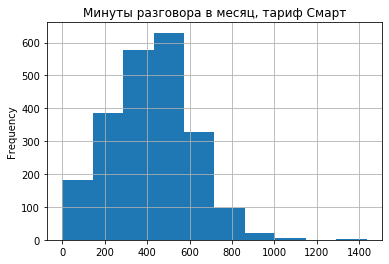

In [38]:
# гистограмма по минутам разговора, тариф Смарт
tariff_option_plot('calls_duration_total_month', 'smart')

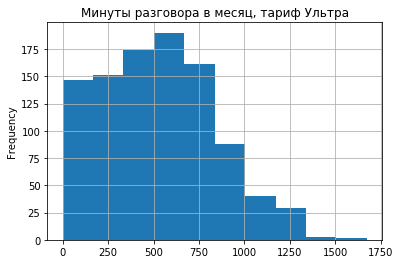

In [39]:
# гистограмма по минутам разговора, тариф Ультра
tariff_option_plot('calls_duration_total_month', 'ultra')

In [40]:
# статистические параметры по минутам разговора
stat_table('calls_duration_total_month')

Пользователи тарифа Смарт в основном говорят в пределах лимита в 500 минут, и чаще всего не переплачивают за разговоры (часть переплачивающих все же есть, и примечательно что такие случаи есть при 1400 минутах - в 3 раза). В то же время пользователи тарифа Ультра используют чуть больше 500 минут при лимите в 3000 минут - запас по разговорам огромны. Возможно, для них более важны Гб трафика или сообщения - смотрим дальше.

Распределения в целом по обоим тарифам похожи, немного скошены влево.

## Анализ использованного интернет-трафика

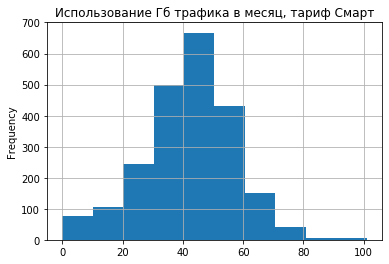

In [41]:
# гистограмма по использованию трафика в Гб, тариф Смарт
tariff_option_plot('gb_used_total_month', 'smart')

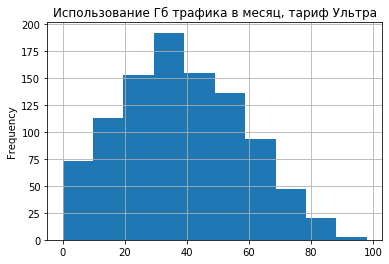

In [42]:
# гистограмма по использованию трафика в Гб, тариф Ультра
tariff_option_plot('gb_used_total_month', 'ultra')

In [43]:
# статистические параметры по использованию трафика
stat_table('gb_used_total_month')

Пользователи обоих тарифов чаще всего выходят за пределы лимитов трафика (15 Гб для Смарт и 30 Гб для Ультра) и переплачивают за трафик сверх лимитов. Медианы и средние лежат рядом, но пользователи Смарт чаще выходят за пределы лимитов, тк он в 2 раза меньше, чем у Ультра.

Распределения похожи на нормальные, имеют медиану посередине и среднее не сильно отличается.

Возможно, бизнесу стоит подумать о том, чтобы расширить лимиты трафика, дать безлимит на основные потребители трафика (обычно это соцсети) или дать возможность конвертировать неиспользвоанные минуты в Гб трафика. Если на рынке появится конкурентный тариф  безлимитом на определенную категорию и лимитом свободного трафика, то "Мегалайн" может начать терять пользователей ввиду злой политики округления (1 Мб иногда приравнивается к 1 Гб - не совсем справедливо).

*Оффтоп:* например, в реальном мире у того же Мегафона есть тариф в коллабе с Вилсой с полным безлимитом на соцсети и Ютуб + 25 Гб трафика куда угодно, и не более чем за 600 руб. в месяц. При этом неиспользованный трафик переходит на следующий месяц - 2 месяца можно тратить, например, по 10 Гб, а на 3-ий хоть все 55 Гб. Я бы на Мегалайн даже не посмотрел при таком варианте.

## Анализ отправленных SMS-сообщений

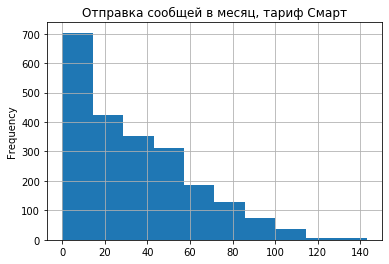

In [44]:
# гистограмма по отправке сообщений, тариф Смарт
tariff_option_plot('messages_sent_total_month', 'smart')

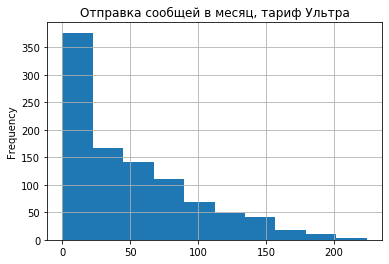

In [45]:
# гистограмма по отправке сообщений, тариф Ультра
tariff_option_plot('messages_sent_total_month', 'ultra')

In [46]:
# статистические параметры по отправке сообщений
stat_table('messages_sent_total_month')

В случае сообщений, пользователи тарифа Ультра за сообщения не переплачивают (лимит 1000 сообщений). Пользователи Смарта иногда выходят за пределы лимита и переплачивают, но и отправляют их чаще. В обоих тарифах довольно много пользователей, кто отправляет их совсем редко или не отправляет совсем.

Распределения похожи, в обоих случаях скошены влево.

**Выводы по разделу:**
- 1) По минутам разговора, пользователи обоих тарифов чаще всего не переплачивают за минуты разговора. В случае тарифа Ультра, стоит переконфигурировать тариф в части уменьшения минут разговора и увеличения лимитов трафика.
- 2) По использованию трафика, пользователи обоих тарифов часто выходят за пределы лимитов - стоит подумать об изменении лимитов и убрать злую политику округления - это не совсем справедливо.
- 3) По отправке сообщений, пользователи обоих тарифов чаще всего не переплачивают за них. Много пользователей, кто пользуется ими редко или не пользуется совсем - это связано с тем, что львиная доля населения сейчас общается в мессенджерах, которые потребляют трафик. Отсюда и выходит высокое потребеление трафика. Бизнесу стоит подробнее изучить использование трафика, и если действительно бОльшая часть трафика уходит на мессенджеры - уменьшить лимит по сообщениям, особенно на тарифе Ультра.

# Проверка гипотез

## Удаление выбросов

Так как выборки данных из предыдущего раздела независимы между собой, будем использовать для теста t-критерий Стьюдента. Этот критерий является довольно чувствительным к выбросам в данных, поэтому перед проверкой гипотез будем отдельно выделять срезы из df и удалять выбросы.

**Гипотеза №1:**

H0: средняя выручка пользователей тарифов Ультра и Смарт не различается;

H1: средняя выручка пользователей тарифов Ультра и Смарт различается.

Имеем дело с гипотезой о равенстве средних 2-х генеральных совокупностей. Необходимы 2 выборки по выручке тарифов Смарт и Ультра.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 8 to 3213
Data columns (total 22 columns):
user_id                       2229 non-null int64
month                         2229 non-null int64
calls_total_month             2229 non-null float64
calls_duration_total_month    2229 non-null float64
gb_used_total_month           2229 non-null float64
messages_sent_total_month     2229 non-null float64
age                           2229 non-null int64
churn_date                    111 non-null datetime64[ns]
city                          2229 non-null object
first_name                    2229 non-null object
last_name                     2229 non-null object
reg_date                      2229 non-null datetime64[ns]
tariff                        2229 non-null object
messages_included             2229 non-null int64
gb_per_month_included         2229 non-null float64
minutes_included              2229 non-null int64
rub_monthly_fee               2229 non-null int64
rub_per_gb  

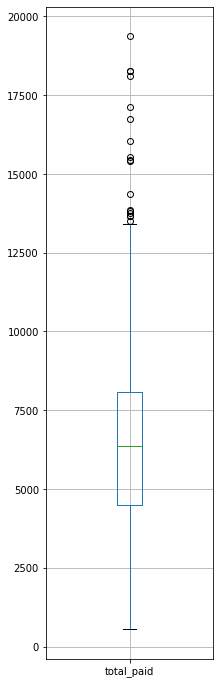

In [47]:
# выделение отдельной выборки по выручке тарифа Смарт, построение boxplot
df_smart = df[df['tariff'] == 'smart']
df_smart.info()
df_smart.boxplot('total_paid', figsize=(3, 12))

Выбросы значений выручки в тарифе Смарт есть.

Считаем выбросами на фоне остальных значения выручки больше 13 500 руб.

In [48]:
# получение среза
df_smart = df_smart.query('total_paid <= 13500')
df_smart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2212 entries, 8 to 3213
Data columns (total 22 columns):
user_id                       2212 non-null int64
month                         2212 non-null int64
calls_total_month             2212 non-null float64
calls_duration_total_month    2212 non-null float64
gb_used_total_month           2212 non-null float64
messages_sent_total_month     2212 non-null float64
age                           2212 non-null int64
churn_date                    111 non-null datetime64[ns]
city                          2212 non-null object
first_name                    2212 non-null object
last_name                     2212 non-null object
reg_date                      2212 non-null datetime64[ns]
tariff                        2212 non-null object
messages_included             2212 non-null int64
gb_per_month_included         2212 non-null float64
minutes_included              2212 non-null int64
rub_monthly_fee               2212 non-null int64
rub_per_gb  

Данных удалено совсем немного, всего 17 значений. Используем `df_smart` для 1 гипотезы.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 0 to 3208
Data columns (total 22 columns):
user_id                       985 non-null int64
month                         985 non-null int64
calls_total_month             985 non-null float64
calls_duration_total_month    985 non-null float64
gb_used_total_month           985 non-null float64
messages_sent_total_month     985 non-null float64
age                           985 non-null int64
churn_date                    76 non-null datetime64[ns]
city                          985 non-null object
first_name                    985 non-null object
last_name                     985 non-null object
reg_date                      985 non-null datetime64[ns]
tariff                        985 non-null object
messages_included             985 non-null int64
gb_per_month_included         985 non-null float64
minutes_included              985 non-null int64
rub_monthly_fee               985 non-null int64
rub_per_gb                    

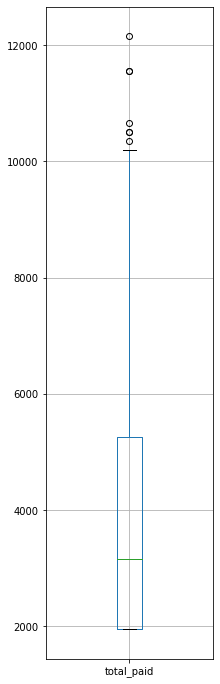

In [49]:
# выделение отдельной выборки по выручке тарифа Ультра, построение boxplot
df_ultra = df[df['tariff'] == 'ultra']
df_ultra.info()
df_ultra.boxplot('total_paid', figsize=(3, 12))

Выбросы в данных также есть.

Считаем выбросами на фоне остальных значения выручки больше 10 100 руб.

In [50]:
# получение среза
df_ultra = df_ultra.query('total_paid <= 10100')
df_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 977 entries, 0 to 3208
Data columns (total 22 columns):
user_id                       977 non-null int64
month                         977 non-null int64
calls_total_month             977 non-null float64
calls_duration_total_month    977 non-null float64
gb_used_total_month           977 non-null float64
messages_sent_total_month     977 non-null float64
age                           977 non-null int64
churn_date                    75 non-null datetime64[ns]
city                          977 non-null object
first_name                    977 non-null object
last_name                     977 non-null object
reg_date                      977 non-null datetime64[ns]
tariff                        977 non-null object
messages_included             977 non-null int64
gb_per_month_included         977 non-null float64
minutes_included              977 non-null int64
rub_monthly_fee               977 non-null int64
rub_per_gb                    

Удалено всего 8 значений. Используем `df_ultra` для 1 гипотезы.

**Гипотеза №2:**

H0: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов;

H1: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Имеем дело с гипотезой о равенстве средних 2-х генеральных совокупностей. Необходимы 2 выборки по выручке в Москве и в остальной России.

In [51]:
# технический вывод уникальных городов
df['city'].sort_values().unique()

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611 entries, 8 to 3208
Data columns (total 22 columns):
user_id                       611 non-null int64
month                         611 non-null int64
calls_total_month             611 non-null float64
calls_duration_total_month    611 non-null float64
gb_used_total_month           611 non-null float64
messages_sent_total_month     611 non-null float64
age                           611 non-null int64
churn_date                    41 non-null datetime64[ns]
city                          611 non-null object
first_name                    611 non-null object
last_name                     611 non-null object
reg_date                      611 non-null datetime64[ns]
tariff                        611 non-null object
messages_included             611 non-null int64
gb_per_month_included         611 non-null float64
minutes_included              611 non-null int64
rub_monthly_fee               611 non-null int64
rub_per_gb                    

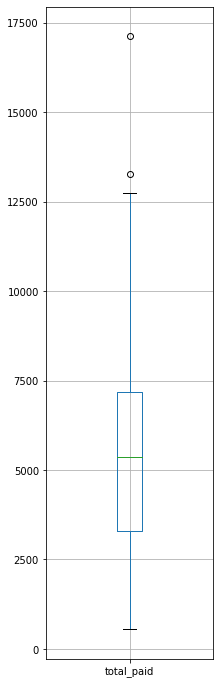

In [52]:
# выделение отдельной выборки по выручке в Москве, построение boxplot
df_moscow = df[df['city'] == 'Москва']
df_moscow.info()
df_moscow.boxplot('total_paid', figsize=(3, 12))

Выбросы в данных по Москве есть.

Считаем выбросами на фоне остальных значения выручки больше 12 700 руб.

In [53]:
# получение среза
df_moscow = df_moscow.query('total_paid <= 12700')
df_moscow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 8 to 3208
Data columns (total 22 columns):
user_id                       607 non-null int64
month                         607 non-null int64
calls_total_month             607 non-null float64
calls_duration_total_month    607 non-null float64
gb_used_total_month           607 non-null float64
messages_sent_total_month     607 non-null float64
age                           607 non-null int64
churn_date                    41 non-null datetime64[ns]
city                          607 non-null object
first_name                    607 non-null object
last_name                     607 non-null object
reg_date                      607 non-null datetime64[ns]
tariff                        607 non-null object
messages_included             607 non-null int64
gb_per_month_included         607 non-null float64
minutes_included              607 non-null int64
rub_monthly_fee               607 non-null int64
rub_per_gb                    

Удалено всего 4 значения. Используем `df_moscow` для 2 гипотезы.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2603 entries, 0 to 3213
Data columns (total 22 columns):
user_id                       2603 non-null int64
month                         2603 non-null int64
calls_total_month             2603 non-null float64
calls_duration_total_month    2603 non-null float64
gb_used_total_month           2603 non-null float64
messages_sent_total_month     2603 non-null float64
age                           2603 non-null int64
churn_date                    146 non-null datetime64[ns]
city                          2603 non-null object
first_name                    2603 non-null object
last_name                     2603 non-null object
reg_date                      2603 non-null datetime64[ns]
tariff                        2603 non-null object
messages_included             2603 non-null int64
gb_per_month_included         2603 non-null float64
minutes_included              2603 non-null int64
rub_monthly_fee               2603 non-null int64
rub_per_gb  

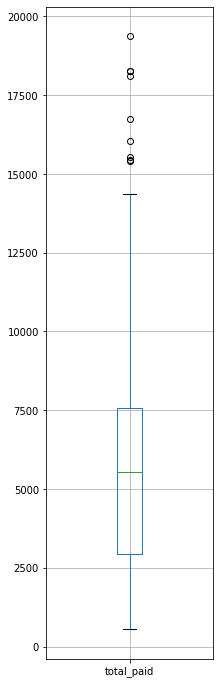

In [54]:
# выделение отдельной выборки по выручке в России, построение boxplot
df_russia = df[df['city'] != 'Москва']
df_russia.info()
df_russia.boxplot('total_paid', figsize=(3, 12))

Выбросы также есть.

Считаем выбросами на фоне остальных значения выручки более 14 500 руб.

In [55]:
# получение среза
df_russia = df_russia.query('total_paid <= 14500')
df_russia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2594 entries, 0 to 3213
Data columns (total 22 columns):
user_id                       2594 non-null int64
month                         2594 non-null int64
calls_total_month             2594 non-null float64
calls_duration_total_month    2594 non-null float64
gb_used_total_month           2594 non-null float64
messages_sent_total_month     2594 non-null float64
age                           2594 non-null int64
churn_date                    146 non-null datetime64[ns]
city                          2594 non-null object
first_name                    2594 non-null object
last_name                     2594 non-null object
reg_date                      2594 non-null datetime64[ns]
tariff                        2594 non-null object
messages_included             2594 non-null int64
gb_per_month_included         2594 non-null float64
minutes_included              2594 non-null int64
rub_monthly_fee               2594 non-null int64
rub_per_gb  

Удалено всего 9 значений. Используем `df_russia` для 2 гипотезы.

**Вывод:** необходимые данные для проверки гипотез получены, можно приступать к самой проверке.
- Для проверки 1 гипотезы используем `df_smart` и `df_ultra`.
- Для проверки 2 гипотезы используем `df_moscow` и `df_russia`.

## Проверка гипотез

Уровень значимости alpha для 2-х гипотез зададим 0.05 - общепринятое значение.

In [56]:
alpha = 0.05

### Проверка гипотезы №1

H0: средняя выручка пользователей тарифов Ультра и Смарт не различается;

H1: средняя выручка пользователей тарифов Ультра и Смарт различается.

In [57]:
# получение значений выручки в виде списка
df_smart_list = df_smart['total_paid'].to_list()
df_ultra_list = df_ultra['total_paid'].to_list()

In [58]:
# проверка гипотезы № 1
results = st.ttest_ind(df_smart_list, df_ultra_list)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0610293107238251e-117
Отвергаем нулевую гипотезу


**Вывод:** Между выборками есть значимые различия, разница в выручках 2-х тарифов не случайна.

Верно утверждение, что средняя выручка тарифов Смарт и Ультра различается. Посмотрим сами цифры.

In [59]:
# вывод средних значений выручки по тарифам
print('Средняя выручка по тарифу Смарт', df_smart['total_paid'].mean())
print('Средняя выручка по тарифу Ультра', df_ultra['total_paid'].mean())

Средняя выручка по тарифу Смарт 6174.386980108499
Средняя выручка по тарифу Ультра 3786.386898669396


Действительно, средняя выручка по тарифам отличается и довольно серьезно - почти в 2 раза.

### Проверка гипотезы №2

H0: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов;

H1: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [60]:
# получение значений выручки в виде списка
df_moscow_list = df_moscow['total_paid'].to_list()
df_russia_list = df_russia['total_paid'].to_list()

In [61]:
# проверка гипотезы № 2
results = st.ttest_ind(df_moscow_list, df_russia_list)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.21932390500098287
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Значимых различий нет. Результат может быть получен с 22%-ой вероятностью.

Верно утверждение, что средняя выручка в Москве и остальных регионах не отличается. Посмотрим сами цифры.

In [62]:
# вывод средний значений выручки по регионам
print('Средняя выручка по пользователям в Москве', df_moscow['total_paid'].mean())
print('Средняя выручка по пользователям в России', df_russia['total_paid'].mean())

Средняя выручка по пользователям в Москве 5340.591433278419
Средняя выручка по пользователям в России 5497.56399383192


Разница в средней выручке несущественна, есть вероятность получить одинаковое среднее.

# Общий вывод

В рамках проекта исследованы данные о пользователях тарифов Смарт и Ультра оператора Мегалайн.

Исходные данные в целом были корректные, большая предобработка не понадобилась. Посчитана и добавлена помесячная статистика использования опций каждым пользователем, рассчитана выручка по каждому пользователю.

Изучено поведение пользователей в разрезе каждого месяца - бизнесу стоит изменить конфигурации по минутам разговора, доступного трафика и лимита сообщений. Также стоит посмотреть на конкурентов - злая политика округления ради большей прибыли может принести ощутимый прирост, но только в краткосрочной перспективе. Рано или поздно при таком настрое компания может начать терять клиентскую базу.

Проверены 2 гипотезы, оказались верными следующие утверждения:
- Средняя выручка тарифов Смарт и Ультра различается почти в 2 раза. Тариф Ультра выгоднее для компании;
- Средняя выручка по пользователям в Москве и остальных регионах РФ не отличается. Нет смысла в привелегиях и эксклюзивных условиях отдельно для Москвы или отдельно для регионов - можно развивать одно предложение для всей России.